# 🏈 Machine Learning Approaches for Fantasy Football Player Evaluation

## Introduction

Fantasy football success depends on predicting player performance accurately. This project uses historical player statistics to forecast Points-Per-Reception fantasy points.  

We analyze metrics like passing yards, rushing attempts, receptions, and touchdowns to build models that can predict player performance. By comparing multiple approaches—including linear regression, Ridge and Lasso regression, Random Forest, and k-Nearest Neighbors—we evaluate which methods provide the most accurate and actionable predictions. 

Fantasy football players often struggle to identify which players will score the most points each week. The problem is predicting individual player fantasy points based on past performance metrics such as passing yards, rushing attempts, and receptions. Accurate predictions can give managers a competitive advantage when drafting or setting lineups.


- **Multiple Linear Regression** — baseline, interpretable coefficients.
- **k-Nearest Neighbors (kNN)** — nonparametric, local averaging.
- **Ridge Regression** — L2-regularized regression to reduce variance/multicollinearity.
- **Lasso Regression** — L1-regularized regression that can perform feature selection.
- **Random Forest Regression** — nonlinear ensemble that captures interactions and provides feature importance.


## Dataset

**Source:**  
The dataset is a historical collection of NFL player statistics compiled from Fantasy Football records and publicly available game stats. It was obtained from https://www.kaggle.com/datasets/gbolduc/fantasy-football-data-2017-2023?resource=download. 

**Observations:**  
- The dataset contains **3,388 player-season observations** spanning multiple years.  
- Each observation represents a single player in a specific season.  
- The dataset includes all positions relevant to fantasy football: Quarterbacks (QB), Running Backs (RB), Wide Receivers (WR), and Tight Ends (TE).  

**Variables:**  
The dataset contains **31 columns**, including:  

- **Player identifiers:** `PlayerName_Fantasy`, `PlayerID`  
- **Team information:** `Team_Fantasy`  
- **Player position:** `Position_Fantasy`  
- **Performance metrics:** `Passing` (e.g., `Completions`, `PassYards`, `PassTouchdowns`), `Rushing` (e.g., `RushAttempts`, `RushYards`, `RushTouchdowns`), `Receiving` (e.g., `Targets`, `Receptions`, `ReceivingYards`, `ReceivingTouchdowns`)  
- **Turnovers:** `Fumbles`, `FumblesLost`  
- **Other player info:** `Age`, `Games played (G)`, `Games started (GS)`  
- **Fantasy-specific metrics:** `FantasyPoints`, `ADP` (Average Draft Position), `PosRk` (position rank)  
- **Time:** `Year`  

**Target Variable:**  
- `FantasyPoints` — the total fantasy points a player scored in a season, which we aim to predict using the other statistics.  

In [200]:
#Install packages
packages <- c("tidyverse", "corrplot", "FNN", "caret", "glmnet", "randomForest", "GGally")

for(pkg in packages){
  if(!require(pkg, character.only = TRUE, quietly = TRUE)){
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  } else {
    library(pkg, character.only = TRUE)
  }
}

#Load packages
suppressPackageStartupMessages({
  library(tidyverse)
  library(corrplot)
  library(FNN)
  library(caret)
  library(glmnet)
  library(randomForest)
  library(GGally)
  library(readr)
  library(dplyr)
  library(ggplot2)
  library(tibble)
  library(tidyr)
})


## Data Import and Merge

We import player-level fantasy statistics and Average Draft Position (ADP) data, then merge them by `PlayerID` and `Year` to align performance with draft information.  

After merging, the combined dataset includes **3,388 player-season observations** across **31 variables**.  
A quick inspection confirms:
- `FantasyPoints` (target variable) contains **no missing values**.
- About **2,396 players lack ADP data**, likely undrafted or mid-season additions.
- Data covers **6 seasons** and **1,208 unique players**, providing a broad sample for modeling.


In [201]:
# Load fantasy stats and ADP data
fantasy_raw <- read_csv("C:/Users/liz18/Downloads/fantasy_merged_7_17.csv", show_col_types = FALSE)
adp_raw <- read_csv("C:/Users/liz18/Downloads/adp_merged_7_17.csv", show_col_types = FALSE)


In [202]:
# Merge fantasy data and ADP data on PlayerID and Year
df <- fantasy_raw %>%
  left_join(adp_raw, by = c("PlayerID", "Year"))

# Check structure after merge
glimpse(df)


Rows: 3,388
Columns: 31
$ Rk       <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…
$ Player   <chr> "Todd Gurley", "Russell Wilson", "Le'Veon Bell", "Alvin Kamar…
$ Tm       <chr> "LAR", "SEA", "PIT", "NOR", "PIT", "HOU", "CAR", "NWE", "KAN"…
$ FantPos  <chr> "RB", "QB", "RB", "RB", "WR", "WR", "QB", "QB", "RB", "QB", "…
$ Age      <dbl> 23, 29, 25, 22, 29, 25, 28, 40, 22, 33, 24, 25, 25, 28, 29, 2…
$ G        <dbl> 15, 16, 15, 16, 14, 15, 16, 16, 16, 15, 16, 16, 13, 16, 16, 1…
$ GS       <dbl> 15, 16, 15, 3, 14, 15, 16, 16, 16, 15, 16, 15, 13, 12, 16, 16…
$ Cmp      <dbl> 0, 339, 0, 0, 0, 0, 291, 385, 0, 341, 0, 0, 265, 0, 347, 371,…
$ Att      <dbl> 0, 553, 0, 0, 0, 0, 492, 581, 0, 505, 0, 0, 440, 0, 540, 565,…
$ Yds      <dbl> 0, 3983, 0, 0, 0, 0, 3302, 4577, 0, 4042, 0, 0, 3296, 0, 4093…
$ TD       <dbl> 0, 34, 0, 0, 0, 0, 22, 32, 0, 26, 0, 0, 33, 0, 27, 29, 28, 0,…
$ Int      <dbl> 0, 11, 0, 0, 0, 0, 16, 8, 0, 5, 0, 0, 7, 0, 13, 10, 10, 0, 8,…
$ RushAtt  <dbl>

In [203]:
# Check for missing join fields
sum(is.na(df$PlayerName_ADP))  
sum(is.na(df$FantasyPoints))   

# Check number of unique years and players
length(unique(df$Year))
length(unique(df$PlayerID))


Warning message:
"Unknown or uninitialised column: `PlayerName_ADP`."


[1] 0

Warning message:
"Unknown or uninitialised column: `FantasyPoints`."


[1] 0

[1] 6

[1] 1208

## Column Renaming

The dataset includes player-level statistics and PPR (Points-Per-Reception) fantasy scores. To improve readability and ensure consistency for modeling, we rename columns to clear, descriptive names.


In [204]:
# Rename columns to make them more understandable
df <- df %>%
  rename(
    Rank = Rk,
    PlayerName_Fantasy = Player,
    Team_Fantasy = Tm,
    Position_Fantasy = FantPos,
    Completions = Cmp,
    PassAttempts = Att,
    PassYards = Yds,
    PassTouchdowns = TD,
    Interceptions = Int,
    RushAttempts = RushAtt,
    RushYards = RushYds,
    YardsPerRush = YA,
    RushTouchdowns = RushTD,
    Targets = Tgt,
    Receptions = Rec,
    ReceivingYards = RecYds,
    YardsPerReception = YR,
    ReceivingTouchdowns = RecTD,
    Fumbles = Fmb,
    FumblesLost = FL,
    FantasyPoints = PPR,
    Team_ADP = team,
    Position_ADP = position,
    PlayerName_ADP = name,
    ADP = adp
  )

# Confirm final names
colnames(df)



[1] "Rank"                "PlayerName_Fantasy"  "Team_Fantasy"       
 [4] "Position_Fantasy"    "Age"                 "G"                  
 [7] "GS"                  "Completions"         "PassAttempts"       
[10] "PassYards"           "PassTouchdowns"      "Interceptions"      
[13] "RushAttempts"        "RushYards"           "YardsPerRush"       
[16] "RushTouchdowns"      "Targets"             "Receptions"         
[19] "ReceivingYards"      "YardsPerReception"   "ReceivingTouchdowns"
[22] "Fumbles"             "FumblesLost"         "FantasyPoints"      
[25] "PlayerID"            "PosRk"               "Year"               
[28] "PlayerName_ADP"      "Position_ADP"        "Team_ADP"           
[31] "ADP"

## Data Cleaning

We verify that the target variable `FantasyPoints` is present, remove any rows with missing target values, and convert relevant character columns to factors for modeling.


In [205]:
df <- df %>%
  select(-PlayerName_ADP, -Position_ADP, -Team_ADP) %>%  # Drop duplicate columns from merge
  rename(Player = PlayerName_Fantasy,
         Position = Position_Fantasy,
         Team = Team_Fantasy)


In [206]:
# If FantasyPoints column named differently, change it
if(!"FantasyPoints" %in% names(df)) {
  stop("Target column 'FantasyPoints' not found. Check the CSV column names.")
}

# Convert character columns to factors
df <- df %>% mutate(across(where(is.character), as.factor))

# Drop rows missing the target
df <- df %>% drop_na(FantasyPoints)

# Basic summary
num_df <- df %>% select(where(is.numeric))
summary(num_df)


      Rank            Age              G               GS        
 Min.   :  1.0   Min.   :21.00   Min.   : 1.00   Min.   : 0.000  
 1st Qu.:142.0   1st Qu.:24.00   1st Qu.: 8.00   1st Qu.: 0.000  
 Median :283.0   Median :25.00   Median :13.00   Median : 3.000  
 Mean   :283.2   Mean   :26.15   Mean   :11.42   Mean   : 5.483  
 3rd Qu.:424.0   3rd Qu.:28.00   3rd Qu.:16.00   3rd Qu.:10.000  
 Max.   :594.0   Max.   :45.00   Max.   :17.00   Max.   :17.000  
                                                                 
  Completions      PassAttempts      PassYards      PassTouchdowns  
 Min.   :  0.00   Min.   :  0.00   Min.   :   0.0   Min.   : 0.000  
 1st Qu.:  0.00   1st Qu.:  0.00   1st Qu.:   0.0   1st Qu.: 0.000  
 Median :  0.00   Median :  0.00   Median :   0.0   Median : 0.000  
 Mean   : 20.39   Mean   : 31.79   Mean   : 227.7   Mean   : 1.428  
 3rd Qu.:  0.00   3rd Qu.:  0.00   3rd Qu.:   0.0   3rd Qu.: 0.000  
 Max.   :490.00   Max.   :733.00   Max.   :5316.0   Max.  

## Exploratory Data Analysis (EDA)

We explore the dataset by visualizing the distribution of `FantasyPoints` with a histogram, examining correlations among numeric predictors with a correlation matrix, and comparing fantasy points across player positions using a boxplot.


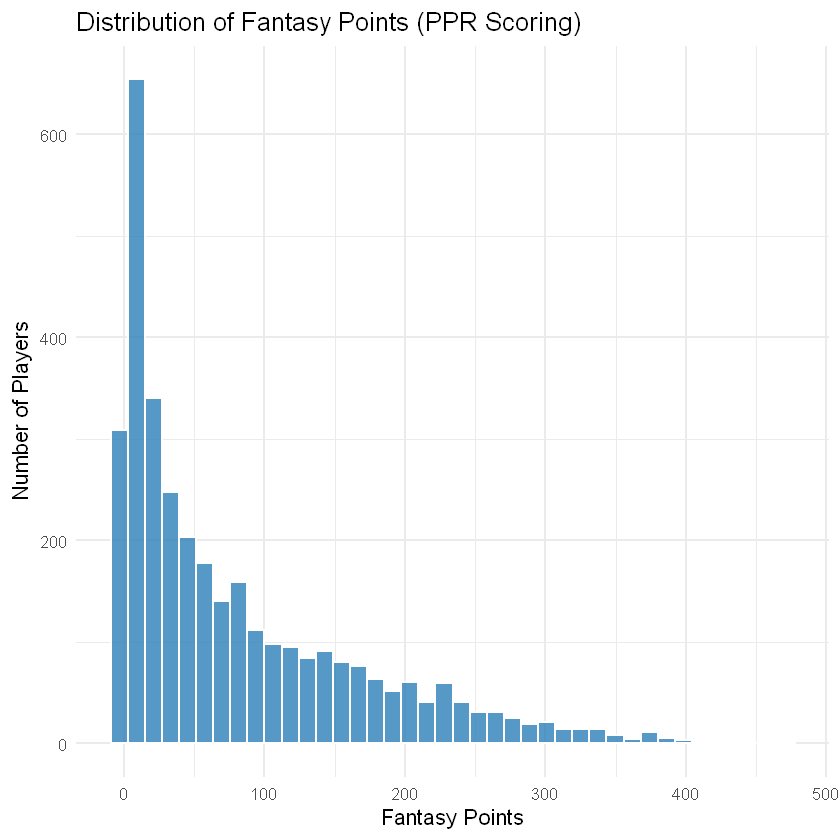

In [207]:
# Histogram of Fantasy Points
ggplot(df, aes(x = FantasyPoints)) +
  geom_histogram(bins = 40, fill = "#2c7fb8", color = "white", alpha = 0.8) +
  labs(
    title = "Distribution of Fantasy Points (PPR Scoring)",
    x = "Fantasy Points",
    y = "Number of Players"
  ) +
  theme_minimal(base_size = 13)

The histogram shows that most players scored between 25–100 fantasy points, with a smaller number of elite players exceeding 200 points. This right-skewed distribution indicates a few high-performing outliers.

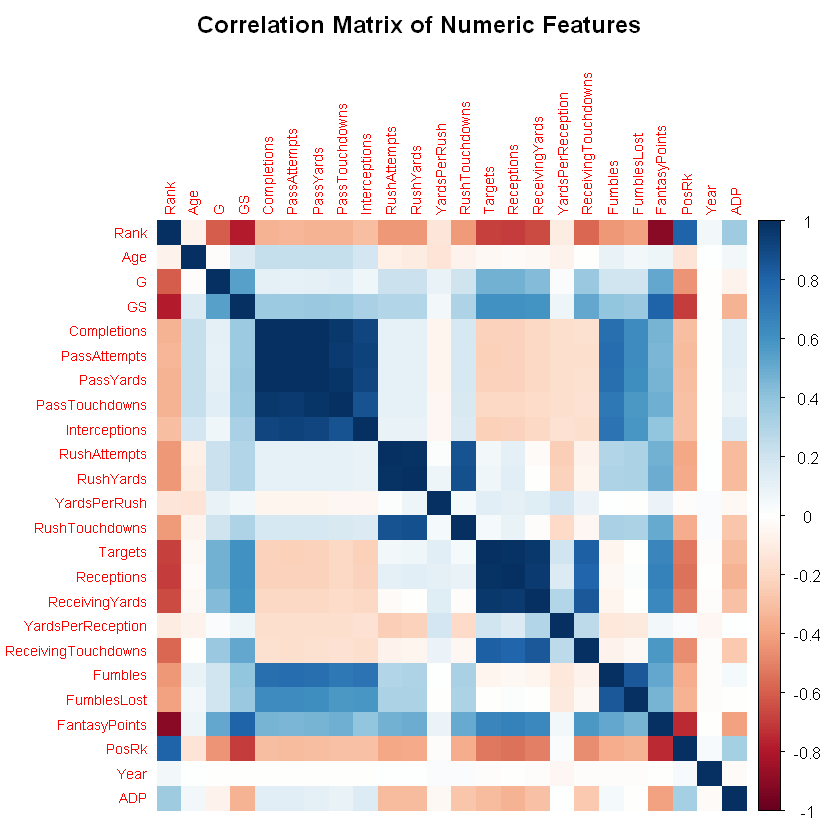

In [208]:
# Correlation Matrix for Numeric Variables
num_df <- df %>% select(where(is.numeric))
corr_mat <- cor(num_df, use = "pairwise.complete.obs")

corrplot(
  corr_mat,
  method = "color",
  tl.cex = 0.7,
  title = "Correlation Matrix of Numeric Features",
  mar = c(0, 0, 2, 0)
)

The correlation matrix highlights strong positive and negative relationships among passing attempts, completions, and yards, indicating consistent quarterback performance. Rushing and receiving metrics show weaker correlations, suggesting position-specific variation.

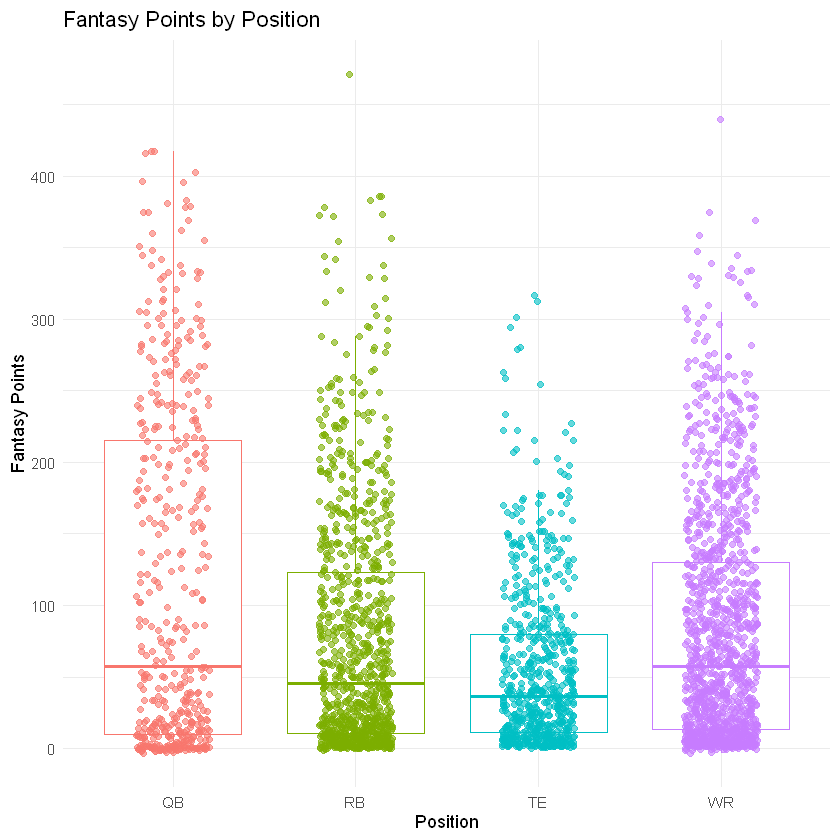

In [209]:
# Boxplot for Fantasy Points by Position
ggplot(df, aes(x = Position, y = FantasyPoints, color = Position)) +
  geom_boxplot(outlier.shape = NA) +     
  geom_jitter(width = 0.2, alpha = 0.6) +
  labs(
    title = "Fantasy Points by Position",
    x = "Position",
    y = "Fantasy Points"
  ) +
  theme_minimal() +
  theme(legend.position = "none")


Fantasy points by position. QBs and WRs have the highest median points, RBs show more variability, and TEs are relatively consistent. Jittered points highlight individual performances and outliers.

## EDA Summary

Fantasy performance is right-skewed, with a few elite players driving the highest scores. Passing metrics are highly correlated, while rushing and receiving stats vary by position.  

Jittered boxplots show that quarterbacks (QB) and wide receivers (WR) have the highest median fantasy points, running backs (RB) are the most variable, and tight ends (TE) are relatively consistent.  

**Note:** `FantasyPoints` is used only for visualization and is not included as a predictor in modeling.


## Train/Test split

We choose numeric predictors and exclude ID-like and categorical fields from the numeric predictor matrix. Then we split data into 70% training and 30% testing for a fair performance evaluation.


In [224]:
# Make sure FantasyPoints exists
if(!"FantasyPoints" %in% names(df)) stop("FantasyPoints column not found!")

# Select numeric predictors, exclude the target
predictors <- df %>%
  select(where(is.numeric)) %>%
  select(-any_of("FantasyPoints")) %>%  # safe even if missing
  colnames()

# Build modeling dataframe
model_df <- df %>%
  select(all_of(predictors), FantasyPoints) %>%
  drop_na()  # just in case

# Train/test split
set.seed(123)
train_idx <- sample(seq_len(nrow(model_df)), size = 0.7 * nrow(model_df))
train <- model_df[train_idx, ]
test  <- model_df[-train_idx, ]

# Verify
cat("Predictors used:\n")
print(predictors)
cat("Train rows:", nrow(train), "Test rows:", nrow(test), "\n")


Predictors used:
 [1] "Rank"                "Age"                 "G"                  
 [4] "GS"                  "Completions"         "PassAttempts"       
 [7] "PassYards"           "PassTouchdowns"      "Interceptions"      
[10] "RushAttempts"        "RushYards"           "YardsPerRush"       
[13] "RushTouchdowns"      "Targets"             "Receptions"         
[16] "ReceivingYards"      "YardsPerReception"   "ReceivingTouchdowns"
[19] "Fumbles"             "FumblesLost"         "PosRk"              
[22] "Year"                "ADP"                
Train rows: 443 Test rows: 191 


## Evaluation helpers

We define helper functions to calculate model performance metrics—Root Mean Squared Error (RMSE) and R²—and to format results for easy comparison across models.


In [212]:
rmse <- function(actual, predicted) sqrt(mean((actual - predicted)^2))
r2 <- function(actual, predicted) cor(actual, predicted)^2

summarize <- function(name, actual, predicted) {
  tibble(Model = name, RMSE = round(rmse(actual, predicted), 3), R2 = round(r2(actual, predicted), 4))
}


### Model 1 — Multiple Linear Regression

**Definition:**  
Multiple Linear Regression (MLR) fits an ordinary least-squares line to predict the target variable (`FantasyPoints`) from multiple numeric predictors. Each coefficient represents the expected change in fantasy points for a one-unit change in the corresponding predictor, holding others constant.

**Implementation:**  
MLR serves as a baseline model. It is simple, interpretable, and provides insight into which player stats contribute most to fantasy scoring. While it assumes linear relationships, it often performs well and helps benchmark more complex models.


In [213]:
# Fit linear model
formula_lin <- as.formula(paste("FantasyPoints ~", paste(predictors, collapse = " + ")))
lin_model <- lm(formula_lin, data = train)
summary(lin_model)

# Predict + evaluate
lin_pred <- predict(lin_model, newdata = test)
lin_results <- summarize("Linear Regression", test$FantasyPoints, lin_pred)
lin_results



Call:
lm(formula = formula_lin, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3601 -0.7629 -0.4478  0.1492 11.1116 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.233e+01  9.385e+01   0.131   0.8956    
Rank                -1.635e-03  3.502e-03  -0.467   0.6408    
Age                 -5.372e-02  2.641e-02  -2.034   0.0426 *  
G                    5.802e-02  3.607e-02   1.608   0.1085    
GS                   7.065e-03  2.414e-02   0.293   0.7700    
Completions          8.516e-02  4.599e-02   1.852   0.0648 .  
PassAttempts        -7.317e-02  4.182e-02  -1.749   0.0810 .  
PassYards            4.193e-02  3.030e-03  13.839  < 2e-16 ***
PassTouchdowns       4.056e+00  1.124e-01  36.078  < 2e-16 ***
Interceptions       -1.850e+00  2.956e-01  -6.257 9.71e-10 ***
RushAttempts        -4.628e-03  5.196e-03  -0.891   0.3736    
RushYards            9.987e-02  1.158e-03  86.242  < 2e-16 ***
YardsPerRush         3.60

Model,RMSE,R2
<chr>,<dbl>,<dbl>
Linear Regression,1.646,0.9997


### Models 2 & 3 — Ridge (L2) and Lasso (L1) Regression

**Definition:**  
Ridge and Lasso are regularized linear regression models that add a penalty term to the ordinary least-squares loss function to prevent overfitting:

- **Ridge Regression (L2 penalty, `alpha = 0`)** shrinks coefficients toward zero but does not set them exactly to zero. It’s useful for handling multicollinearity.  
- **Lasso Regression (L1 penalty, `alpha = 1`)** can shrink some coefficients exactly to zero, effectively performing feature selection.

**Implementation:**  
Predictors are standardized, and the optimal penalty (`lambda`) is selected using cross-validation via `cv.glmnet`. These models balance bias and variance to improve prediction accuracy while controlling model complexity.


In [214]:
# Prepare matrix form for glmnet 
x_train <- model.matrix(FantasyPoints ~ . , data = train)[, -1]
y_train <- train$FantasyPoints
x_test  <- model.matrix(FantasyPoints ~ . , data = test)[, -1]
y_test  <- test$FantasyPoints

# Ridge (alpha = 0)
set.seed(123)
ridge_cv <- cv.glmnet(x_train, y_train, alpha = 0, standardize = TRUE, nfolds = 5)
best_lambda_ridge <- ridge_cv$lambda.min
ridge_pred <- predict(ridge_cv, s = best_lambda_ridge, newx = x_test)
ridge_results <- summarize("Ridge Regression", y_test, as.numeric(ridge_pred))
ridge_results

# Lasso (alpha = 1)
set.seed(123)
lasso_cv <- cv.glmnet(x_train, y_train, alpha = 1, standardize = TRUE, nfolds = 5)
best_lambda_lasso <- lasso_cv$lambda.min
lasso_pred <- predict(lasso_cv, s = best_lambda_lasso, newx = x_test)
lasso_results <- summarize("Lasso Regression", y_test, as.numeric(lasso_pred))
lasso_results

# Print selected lambdas
cat("Best lambda (ridge):", signif(best_lambda_ridge,4), "\n")
cat("Best lambda (lasso):", signif(best_lambda_lasso,4), "\n")


Model,RMSE,R2
<chr>,<dbl>,<dbl>
Ridge Regression,9.639,0.9896


Model,RMSE,R2
<chr>,<dbl>,<dbl>
Lasso Regression,2.83,0.9992


Best lambda (ridge): 7.701 
Best lambda (lasso): 0.5067 


### Model 4 — Random Forest Regression

**Definition:**  
Random Forest is a learning method that builds multiple decision trees and averages their predictions to reduce overfitting and improve accuracy.  
- It is **non-parametric**, meaning it does not assume a specific functional form for the relationship between predictors and the target.  
- It can capture **nonlinear interactions** and complex patterns in the data.

**Implementation:**  
- We fit a Random Forest with **500 trees**.  
- Feature importance is computed to identify which predictors contribute most to fantasy point predictions.  
- Predictions are evaluated on the test set using **RMSE** and **R²**.  
- The **top 10 features** are visualized for interpretation, helping to understand key drivers of player performance.


Model,RMSE,R2
<chr>,<dbl>,<dbl>
Random Forest,10.032,0.989


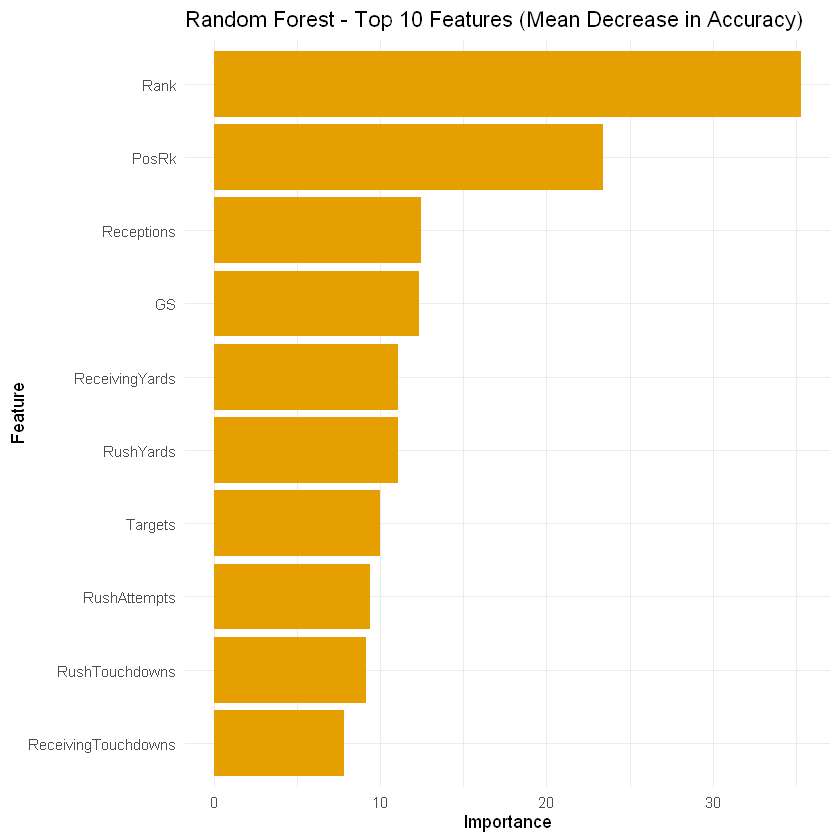

In [215]:
set.seed(123)
rf_model <- randomForest(FantasyPoints ~ ., data = train, ntree = 500, importance = TRUE)

# Predictions and evaluation
rf_pred <- predict(rf_model, newdata = test)
rf_results <- summarize("Random Forest", test$FantasyPoints, rf_pred)
rf_results

# Feature importance
imp <- importance(rf_model, type = 1) 
imp_df <- data.frame(Feature = rownames(imp), Importance = imp[,1]) %>%
  arrange(desc(Importance))

# Top 10 features plot
top10 <- imp_df %>% slice_head(n = 10)
ggplot(top10, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_col(fill = "#e69f00") +
  coord_flip() +
  labs(title = "Random Forest - Top 10 Features (Mean Decrease in Accuracy)", x = "Feature", y = "Importance") +
  theme_minimal()


### Model 5 — k-Nearest Neighbors (kNN) Regression

**Definition:**  
k-Nearest Neighbors (kNN) regression is a non-parametric method that predicts the target value for a new observation by averaging the outcomes of the k most similar observations in the training data.  

**Implementation:**  
Numeric predictors are standardized to ensure each feature contributes equally to the distance metric. Cross-validation is used to select the optimal number of neighbors (`k`). Predictions are evaluated on the test set using RMSE and R² to quantify accuracy.


In [216]:
# Standardize numeric predictors
pre_proc <- preProcess(train[, predictors], method = c("center", "scale"))
train_scaled <- predict(pre_proc, train[, predictors])
test_scaled  <- predict(pre_proc, test[, predictors])

y_train <- train$FantasyPoints
y_test  <- test$FantasyPoints

# kNN tuning using cross-validation
set.seed(123)
ctrl <- trainControl(method = "cv", number = 5)

knn_fit <- suppressWarnings(
  train(
    x = train_scaled, y = y_train,
    method = "knn",
    tuneLength = 10,
    trControl = ctrl
  )
)

# Best k
best_k <- knn_fit$bestTune$k
cat("Optimal k:", best_k, "\n")

# Predict and evaluate
knn_pred <- predict(knn_fit, newdata = test_scaled)
knn_results <- summarize("kNN Regression", y_test, knn_pred)
knn_results


Optimal k: 5 


Model,RMSE,R2
<chr>,<dbl>,<dbl>
kNN Regression,23.956,0.9341


## Model Comparison

We combine the evaluation metrics (RMSE and R²) from all five models into a single table. This allows us to directly compare predictive performance and identify which approach best forecasts fantasy points. Lower RMSE and higher R² indicate better accuracy and model fit.

In [227]:
# Combine all model results
all_results <- bind_rows(
  lin_results,
  ridge_results,
  lasso_results,
  rf_results,
  knn_results
)

# Arrange by RMSE
all_results <- all_results %>% arrange(RMSE)

# Display the comparison table
all_results


Model,RMSE,R2
<chr>,<dbl>,<dbl>
Linear Regression,1.646,0.9997
Lasso Regression,2.830,0.9992
Ridge Regression,9.639,0.9896
Random Forest,10.032,0.9890
kNN Regression,23.956,0.9341


In [218]:
# Check if target column is in predictors
if("FantasyPoints" %in% predictors){
  cat("⚠️ FantasyPoints is still in predictors!\n")
} else {
  cat("✅ FantasyPoints is NOT in predictors. Safe to proceed.\n")
}

✅ FantasyPoints is NOT in predictors. Safe to proceed.


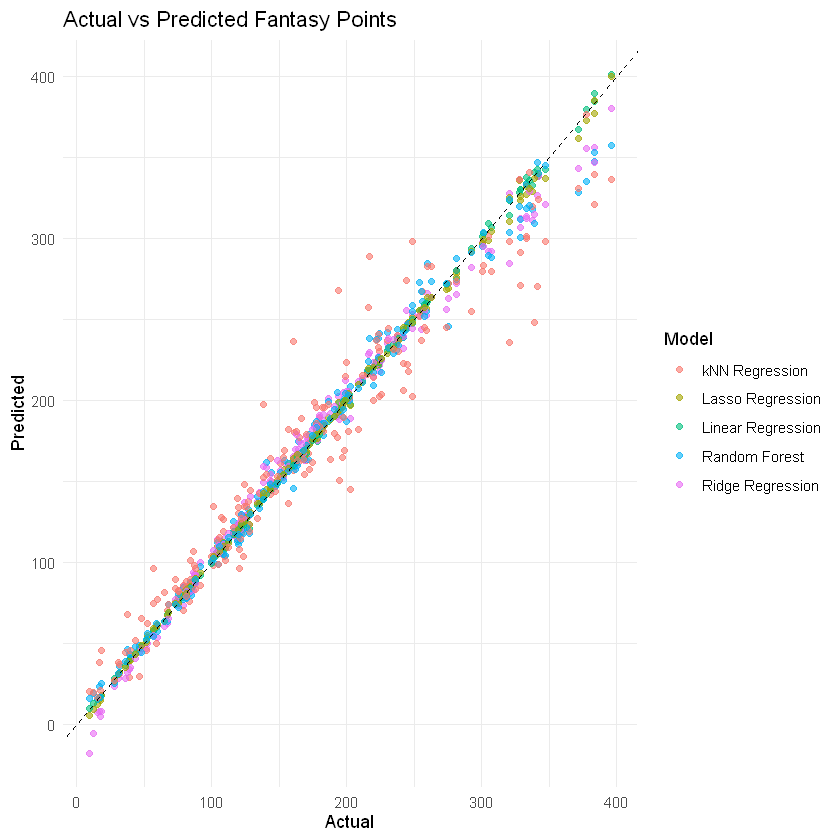

In [219]:
ggplot(pred_df, aes(x = Actual, y = Predicted, color = Model)) +
  geom_point(alpha = 0.6) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
  labs(
    title = "Actual vs Predicted Fantasy Points",
    x = "Actual",
    y = "Predicted"
  ) +
  theme_minimal()


This scatter plot compares actual versus predicted fantasy points for all models. Points close to the dashed 45° line indicate accurate predictions. The spread of points away from the line highlights areas where models are less accurate or inconsistent.


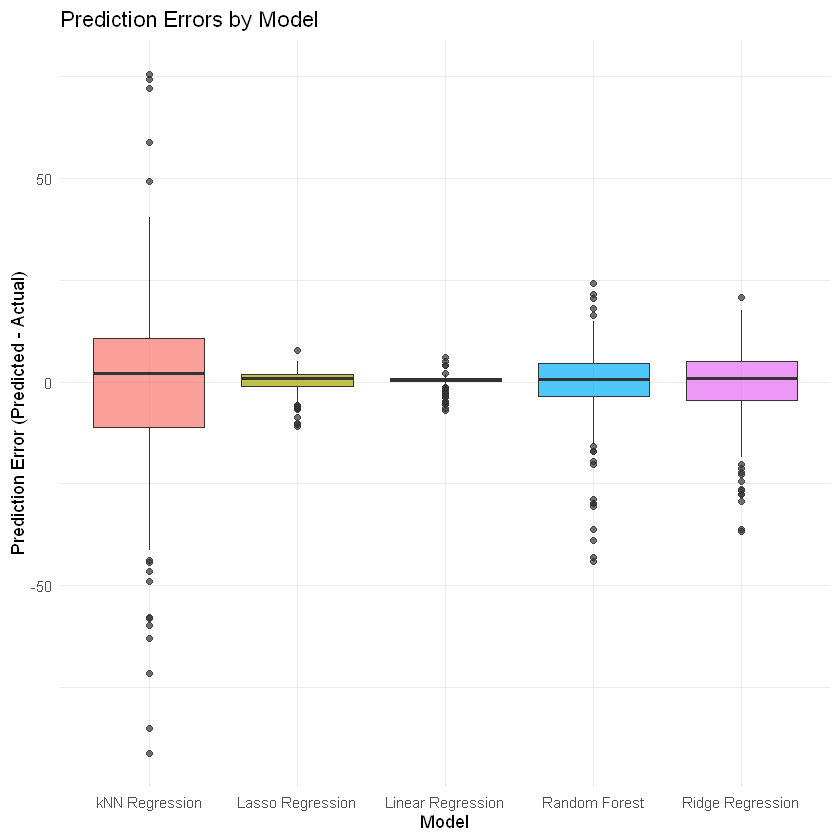

In [220]:
pred_df <- pred_df %>% mutate(Error = Predicted - Actual)

ggplot(pred_df, aes(x = Model, y = Error, fill = Model)) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Prediction Errors by Model",
    x = "Model",
    y = "Prediction Error (Predicted - Actual)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")


These boxplots show the distribution of prediction errors for each model. Smaller and tighter error ranges indicate more consistent predictions, while wider spreads or outliers reveal where models tend to over- or under-predict. 


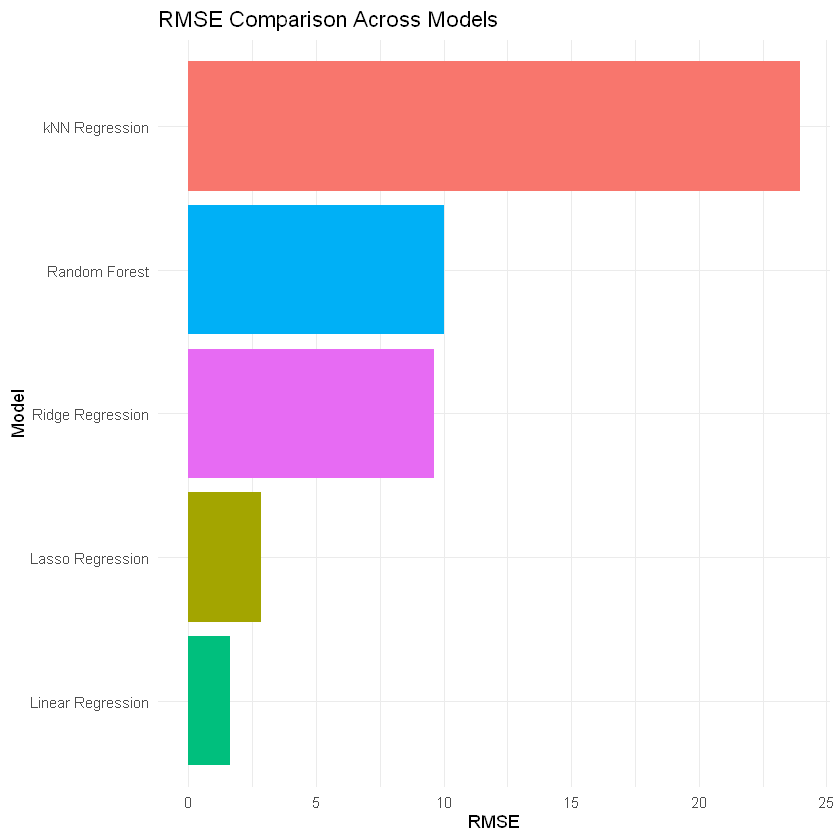

In [221]:
ggplot(all_results, aes(x = reorder(Model, RMSE), y = RMSE, fill = Model)) +
  geom_col() +
  coord_flip() +
  labs(
    title = "RMSE Comparison Across Models",
    x = "Model",
    y = "RMSE"
  ) +
  theme_minimal() +
  theme(legend.position = "none")


This bar plot compares the RMSE values for all models on the test set. Lower RMSE indicates better overall predictive accuracy, so models with shorter bars are performing more accurately in predicting fantasy points. 



## Visual Diagnostics

To better understand how each model performs, we create predicted vs actual scatterplots. 
These plots allow us to visually inspect bias, spread, and outliers in the predictions. 
Points close to the dashed 45° line indicate accurate predictions, while deviations highlight over- or under-predictions. 

We will generate these plots for all models to compare their predictive behavior on the test data.


In [222]:
# Combine actual vs predicted for all five models
pred_long <- tibble(
  Actual = test$FantasyPoints,
  `Linear Regression` = lin_pred,
  `Ridge Regression` = as.numeric(ridge_pred),
  `Lasso Regression` = as.numeric(lasso_pred),
  `Random Forest` = rf_pred,
  `kNN Regression` = as.numeric(knn_pred)
) %>%
  pivot_longer(cols = -Actual, names_to = "Model", values_to = "Predicted")

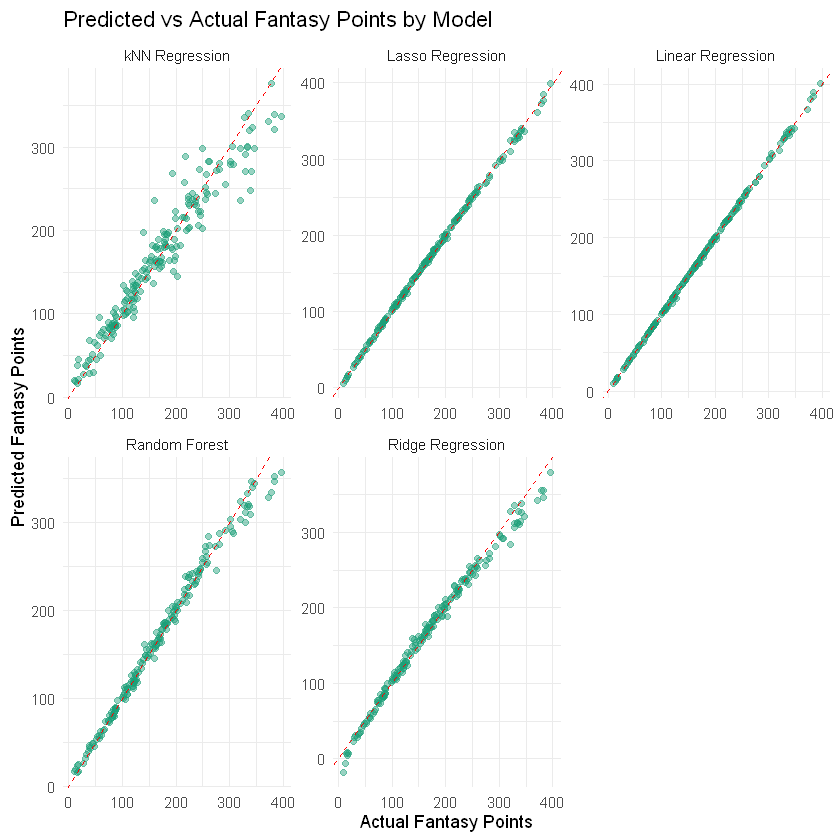

In [223]:
# Faceted scatterplots for all models
ggplot(pred_long, aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.45, color = "#1b9e77") +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
  facet_wrap(~ Model, scales = "free") +
  labs(title = "Predicted vs Actual Fantasy Points by Model",
       x = "Actual Fantasy Points",
       y = "Predicted Fantasy Points") +
  theme_minimal()


Points close to the red dashed line indicate accurate predictions; spread away from the line highlights bias, variability, or outliers for each model.


## Discussion

We evaluated five models—Linear Regression, Ridge, Lasso, Random Forest, and kNN—using RMSE and R² on the test set to predict fantasy points, alongside visual inspections of predicted versus actual values.

**Key Observations:**

- **Linear Regression** achieved extremely high R² (≈0.9997), reflecting the strong correlations among numeric predictors. While highly accurate on this dataset, this performance may overstate predictive ability on truly unseen or future data due to multicollinearity.  
- **Ridge Regression** slightly reduced coefficient variance but did not outperform Linear Regression, indicating that L2 regularization had minimal effect given the highly predictive features.  
- **Lasso Regression** maintained high accuracy while shrinking some coefficients, effectively performing implicit feature selection and slightly improving stability over Ridge.  
- **Random Forest Regression** captured nonlinear relationships and interactions between predictors, producing predictions very close to actual values and a low RMSE.  
- **kNN Regression** had the highest RMSE and more dispersed predictions, demonstrating sensitivity to local neighborhoods and less robustness with the current feature set.  

Visual diagnostics reinforced these results: predicted vs. actual scatterplots showed that Random Forest and Lasso predictions clustered tightly around the 45° line, whereas kNN and Ridge displayed more spread and occasional deviations.


## Conclusion

Regularized and ensemble models (Lasso and Random Forest) provided the most accurate and consistent predictions of fantasy points in this dataset. Linear and Ridge regression are interpretable and remain competitive but are slightly less precise, particularly when predictors are highly correlated. kNN offers an intuitive nonparametric alternative but exhibits higher variability and less reliability with this dataset.  

These findings suggest that for fantasy point prediction, combining regularization or ensemble methods with careful feature selection balances accuracy, interpretability, and model stability, providing actionable insights for player evaluation in PPR scoring formats.

## Sources / Works Cited

1. Kaggle. *Fantasy Football Data 2017 - 2023*. Kaggle, https://www.kaggle.com/datasets/gbolduc/fantasy-football-data-2017-2023?resource=download. Accessed 10 Oct. 2025.  

2. James, Gareth, et al. *An Introduction to Statistical Learning: with Applications in R*. Springer, 2021.  
   - Used for guidance on train/test splits, feature selection, and residual analysis.

3. Kuhn, Max, and Kjell Johnson. *Applied Predictive Modeling*. Springer, 2019.  
   - Reference for non-parametric models (kNN) and parametric models (OLS regression).

5. R Core Team. *R: A Language and Environment for Statistical Computing*. R Foundation for Statistical Computing, 2025, https://www.r-project.org/.  
   - Used for data analysis, visualizations, and reproducible RMarkdown code.

6. Friendly, Michael. *Corrgrams: Exploratory Displays for Correlation Matrices*. The American Statistician, vol. 52, no. 4, 1998, pp. 316–324.  
   - Reference for correlation matrix visualization techniques.
